In [1]:
######## snakemake preamble start (automatically inserted, do not edit) ########
library(methods)
Snakemake <- setClass(
    "Snakemake",
    slots = c(
        input = "list",
        output = "list",
        params = "list",
        wildcards = "list",
        threads = "numeric",
        log = "list",
        resources = "list",
        config = "list",
        rule = "character",
        bench_iteration = "numeric",
        scriptdir = "character",
        source = "function"
    )
)
snakemake <- Snakemake(
    input = list('rds' = 'out/ipynb/compute_differential_methylation/all_unpaired.rds'),
    output = list('xlsx' = 'out/ipynb/visualize_heatmap_by_gene/CUX2.xlsx'),
    params = list(),
    wildcards = list('dev_unpaired', "design" = 'dev_unpaired'),
    threads = 2,
    # log = list('out/ipynb/compute_differential_methylation/dev_unpaired.rds', 'out/ipynb/compute_differential_methylation/dev_unpaired.r.ipynb', "rds" = 'out/ipynb/compute_differential_methylation/dev_unpaired.rds', "notebook" = 'out/ipynb/compute_differential_methylation/dev_unpaired.r.ipynb'),
    resources = list('tmpdir', "tmpdir" = '/tmp'),
    config = list(),
    rule = 'ipynb_compute_differential_methylation',
    bench_iteration = as.numeric(NA),
    scriptdir = '/mnt/thymus/synoSalva/illumina_sequencing_data/mw/mw-oncodiag/src/snakemake/rules/../../ipynb',
    source = function(...){
        wd <- getwd()
        setwd(snakemake@scriptdir)
        source(...)
        setwd(wd)
    }
)
setwd('/mnt/thymus/synoSalva/illumina_sequencing_data/mw/mw-oncodiag/');

######## snakemake preamble end #########


In [2]:
# start coding here

In [3]:
IRdisplay::display_markdown(
    sprintf(
"_Visualize heatmap all CG by gene_

__Oncodiag project__

[Guillaume Charbonnier](mailto:gc.bioinfo@gmail.com)

%s",
        format(Sys.Date(), "%Y-%m-%d")
    )
)

_Visualize heatmap all CG by gene_

__Oncodiag project__

[Guillaume Charbonnier](mailto:gc.bioinfo@gmail.com)

2025-06-10

# Abstract

The aim of this analysis is to produce heatmaps for all differentially methylated CG for the key genes of interest: SLC23A2, ANXA3 and CUX2.

# Methods

## Load dependencies

### Packages

In [4]:
if (!require("BiocManager", quietly = TRUE)) {
    install.packages(
        "BiocManager",
        quiet = TRUE
    )
}
packages <- c(
  "data.table",
  "dplyr",
  "openxlsx",
  "DT",
  # "methylSig",
  "DSS",
  "bsseq",
  "ChIPpeakAnno",
  # "ChIPseeker",
  # "methyAnalysis",
  "org.Hs.eg.db",
  "TxDb.Hsapiens.UCSC.hg19.knownGene",
  # "EnhancedVolcano",
  # "data.table",
  "ggpubr",
  "ComplexHeatmap",
  "tidyr"
)
BiocManager::install(
    packages,
    update = FALSE,
    quiet = TRUE,
    Ncpus = parallel::detectCores()
)
invisible(
    lapply(
      packages,
      library,
      character.only = TRUE
    )
)

Bioconductor version '3.17' is out-of-date; the current release version '3.21'
  is available with R version '4.5'; see https://bioconductor.org/install



'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.17 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'data.table' 'dplyr' 'openxlsx' 'DT' 'DSS'
  'bsseq' 'ChIPpeakAnno' 'org.Hs.eg.db' 'TxDb.Hsapiens.UCSC.hg19.knownGene'
  'ggpubr' 'ComplexHeatmap' 'tidyr'”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dp

In [5]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /cobelix/spicuglia/mambaforge/envs/rkernel_diff_meth_v2/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C.UTF-8  LC_MONETARY=C       LC_MESSAGES=C.UTF-8
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

time zone: Europe/Paris
tzcode source: system (glibc)

attached base packages:
 [1] grid      parallel  stats4    stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] tidyr_1.3.1                            
 [2] ComplexHeatmap_2.16.0                  
 [3] ggpubr_0.6.0                           
 [4] ggplot2_3.4.4                          
 [5] TxDb.Hsapiens.UCSC.hg19.knownGene_3.2.2
 [6] GenomicFeatures_1.52.1           

In [6]:
set_plot_dim <- function(
    width = 16,
    height = 9
) {
    options(
        #jupyter.plot_scale=1,
        repr.plot.width = width,
        repr.plot.height = height
    )
}
set_plot_dim()

### Data

In [7]:
# dml_res <- readRDS(snakemake@input$rds)
dml_res <- readRDS("out/ipynb/compute_differential_methylation/all_unpaired.rds")
dim(dml_res)

[1] 55329507       11

In [8]:
dml_signif_res = callDML(
    dml_res,
    delta = 0.2,
    p.threshold = 0.001
)
dim(dml_signif_res)

[1] 1144667      12

In [9]:
# We need to move to the assay directory, else subsetting will not work
setwd("out/ipynb/compute_differential_methylation/all_unpairedhdf5a/")

In [10]:
se <- readRDS("se.rds")
se

An object of type 'BSseq' with
  55628636 methylation loci
  30 samples
has not been smoothed
Some assays are HDF5Array-backed

In [17]:
rowRanges(se)

GRanges object with 55628636 ranges and 0 metadata columns:
             seqnames    ranges strand
                <Rle> <IRanges>  <Rle>
         [1]        1     10468      *
         [2]        1     10469      *
         [3]        1     10470      *
         [4]        1     10471      *
         [5]        1     10483      *
         ...      ...       ...    ...
  [55628632]       MT     16495      *
  [55628633]       MT     16541      *
  [55628634]       MT     16542      *
  [55628635]       MT     16564      *
  [55628636]       MT     16565      *
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

In [91]:
# Instead of taking the first 500 DML, we will take the top 1745 DML because we want to visualize the top500 after filtering the complete cases.
top500_dml_res <- dml_res[order(dml_res$pval),][1:1745,]
top500_dml_res


,chr,pos,mu1,mu2,diff,diff.se,stat,phi1,phi2,pval,fdr
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3636747,1,206090388,0.8660322,0.6276858,0.2383464,0.005022554,47.45522,0.05147487,0.03380587,0.000000e+00,0.000000e+00
29602612,10,37461855,0.5142400,0.8413245,-0.3270845,0.008491658,-38.51834,0.05147487,0.03380587,0.000000e+00,0.000000e+00
40122574,15,32647306,0.6110721,0.9302312,-0.3191590,0.006916668,-46.14347,0.05147487,0.03380587,0.000000e+00,0.000000e+00
42536867,16,32313549,0.2614794,0.7146251,-0.4531457,0.011711715,-38.69166,0.05147487,0.03380587,0.000000e+00,0.000000e+00
6153221,2,89617212,0.3506720,0.7370125,-0.3863405,0.009297291,-41.55409,0.05147487,0.03380587,0.000000e+00,0.000000e+00
6161672,2,90428575,0.5377291,0.8386734,-0.3009442,0.006790847,-44.31616,0.05147487,0.03380587,0.000000e+00,0.000000e+00
6242652,2,98128595,0.3712793,0.5523461,-0.1810668,0.003476148,-52.08833,0.05147487,0.03380587,0.000000e+00,0.000000e+00
49561280,20,6172855,0.4486904,0.8943422,-0.4456517,0.009016442,-49.42657,0.05147487,0.03388406,0.000000e+00,0.000000e+00
10372600,3,99452818,0.4816781,0.9338716,-0.4521934,0.011278619,-40.09298,0.05147487,0.03380587,0.000000e+00,0.000000e+00


In [92]:
gr_top500 <- GRanges(
    seqnames = top500_dml_res$chr,
    ranges = IRanges(start = top500_dml_res$pos, end = top500_dml_res$pos)
)
se_top500 <- subsetByOverlaps(se, gr_top500)
se_top500

An object of type 'BSseq' with
  1745 methylation loci
  30 samples
has not been smoothed
Some assays are HDF5Array-backed

In [93]:
B_top500 <- as.matrix(getMeth(se_top500, type = "raw"))
B_top500 <- B_top500[complete.cases(B_top500), ]
B_top500

ODG_080,ODG_081,ODG_082,ODG_083,ODG_084,ODG_085,ODG_086,ODG_087,ODG_088,ODG_089,⋯,ODG_100,ODG_101,ODG_102,ODG_103,ODG_104,ODG_105,ODG_106,ODG_107,ODG_108,ODG_109
0.14285714,0.12500000,0.10000000,0.2500000,0.12500000,0.5555556,0.00000000,0.3333333,0.18181818,0.6666667,⋯,0.12500000,0.3076923,0.0000000,0.5000000,0.06250000,0.3333333,0.00000000,0.5000000,0.16666667,0.6000000
0.00000000,0.50000000,0.00000000,0.8333333,0.00000000,0.7777778,0.00000000,0.5862069,0.18181818,0.7142857,⋯,0.00000000,0.7777778,0.0000000,0.6666667,0.15789474,0.4000000,0.14285714,0.7777778,0.20000000,0.8518519
0.00000000,0.41666667,0.12500000,0.8333333,0.00000000,0.7500000,0.21428571,0.4482759,0.07692308,0.5555556,⋯,0.00000000,0.7000000,0.3333333,0.6785714,0.05263158,0.5000000,0.12500000,0.6250000,0.09523810,0.7307692
0.00000000,0.46153846,0.00000000,0.8571429,0.00000000,0.6666667,0.07142857,0.5172414,0.07692308,0.4444444,⋯,0.00000000,0.7894737,0.0000000,0.7000000,0.00000000,0.3333333,0.00000000,0.7777778,0.18181818,0.8275862
0.00000000,0.41666667,0.00000000,0.8571429,0.00000000,0.6666667,0.13333333,0.5000000,0.00000000,0.4000000,⋯,0.00000000,0.7894737,0.0000000,0.7500000,0.10000000,0.4444444,0.00000000,0.8750000,0.18181818,0.8076923
0.11111111,0.46153846,0.00000000,0.8571429,0.09090909,0.6363636,0.06666667,0.4230769,0.20000000,0.4545455,⋯,0.14285714,0.8421053,0.0000000,0.6969697,0.00000000,0.5555556,0.00000000,0.7500000,0.08333333,0.8181818
0.00000000,0.38461538,0.00000000,0.8571429,0.00000000,0.6363636,0.20000000,0.4814815,0.00000000,0.5454545,⋯,0.14285714,0.8947368,0.0000000,0.7352941,0.09523810,0.8000000,0.00000000,0.8750000,0.16666667,0.8181818
0.00000000,0.41666667,0.11111111,0.8750000,0.08333333,0.6363636,0.15384615,0.4615385,0.07142857,0.4545455,⋯,0.14285714,0.8823529,0.0000000,0.7096774,0.18181818,0.7000000,0.00000000,0.6666667,0.21739130,0.7777778
0.00000000,0.33333333,0.25000000,0.8888889,0.00000000,0.5555556,0.00000000,0.3636364,0.14285714,0.4000000,⋯,0.00000000,0.8125000,0.0000000,0.6296296,0.04761905,0.4444444,0.00000000,0.6666667,0.04545455,0.8333333
0.00000000,0.42857143,0.00000000,0.8181818,0.00000000,0.3333333,0.18750000,0.6521739,0.14285714,0.2000000,⋯,0.14285714,0.9090909,0.0000000,0.7692308,0.35294118,0.5454545,0.00000000,1.0000000,0.20000000,0.7941176


In [94]:
patient_colors <- setNames(
    colorRampPalette(RColorBrewer::brewer.pal(12, "Set3"))(length(unique(colData(se)$patient_number))),
    as.character(sort(unique(colData(se)$patient_number)))
)
patient_colors


1         2         3         4         5         6         7         8 
"#8DD3C7" "#E6F5B7" "#D9D7C9" "#D3A5B4" "#E9877F" "#88ADCC" "#D9B382" "#D8C965" 
        9        10        11        12        13        14        15 
"#C7D98C" "#F9CDE4" "#DED7DA" "#C69FC7" "#C2ADC0" "#D6EBB2" "#FFED6F"

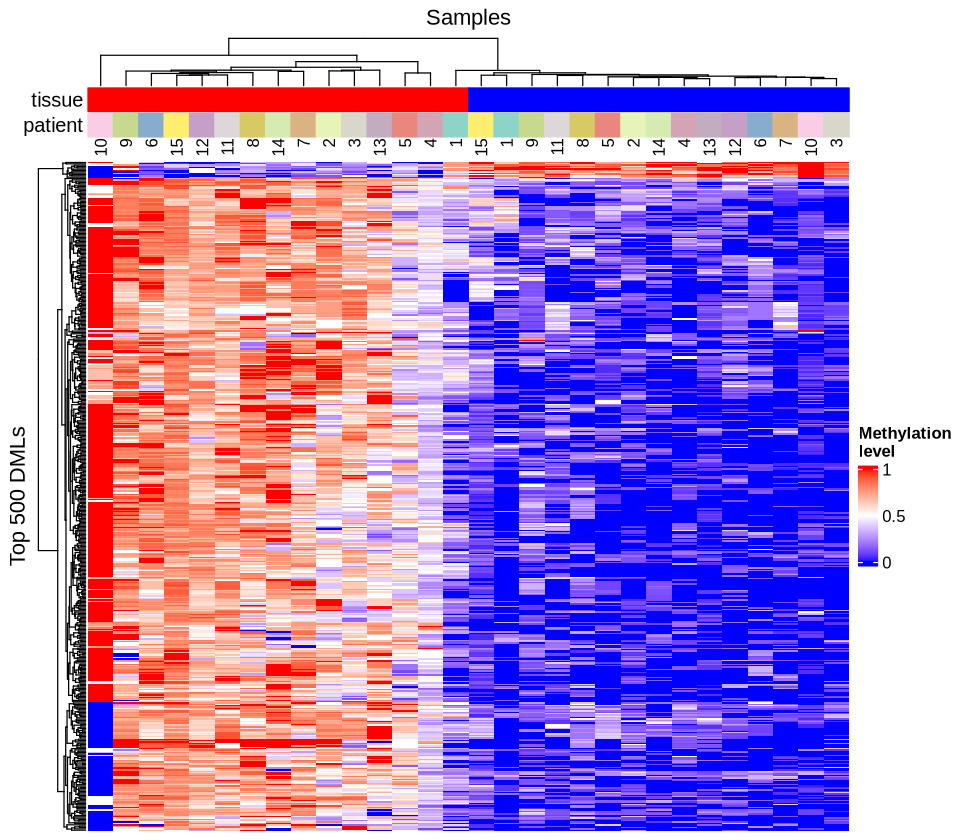

In [95]:
set_plot_dim(8,7)
Heatmap(
    matrix = B_top500,
    name = "Methylation",
    col = circlize::colorRamp2(c(0, 0.5, 1), c("blue", "white", "red")),
    row_title = "Top 500 DMLs",
    column_title = "Samples",
    show_row_names = FALSE,
    top_annotation = HeatmapAnnotation(
        tissue = anno_simple(
            colData(se)$tissue,
            col = c("tumoral" = "red", "normal" = "blue"),
        ),
        annotation_name_side = "left",
        patient = anno_simple(
            colData(se)$patient_number,
            col = patient_colors
        ),
        patient_number_label = anno_text(
            as.character(colData(se)$patient_number),
            # rot = 0,
            # just = "center",
            gp = gpar(fontsize = 10, col = "black")
        )
    ),
    show_column_names = FALSE,
    cluster_rows = TRUE,
    cluster_columns = TRUE,
    heatmap_legend_param = list(title = "Methylation\nlevel")
)